# HM1: Logistic Regression.

### Name: Conor McGullam


#### For this assignment, you will build 6 models. You need to train Logistic Regression/Regularized Logistic Regression each with Batch Gradient Descent, Stochastic Gradient Descent and Mini Batch Gradient Descent. Also, you should plot their objective values versus epochs and compare their training and testing accuracy. You will need to tune the parameters a little bit to obtain reasonable results.

#### You do not have to follow the following procedure. You may implement your own functions and methods, but you need to show your results and plots.

In [17]:
# Load Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# 1. Data processing

- Download the Breast Cancer dataset from canvas or from https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)
- Load the data.
- Preprocess the data.

## 1.1. Load the data

In [18]:
data = pd.read_csv("data-1.csv")

## 1.2 Examine and clean data

In [19]:
# Some columns may not be useful for the model (For example, the first column contains ID number which may be irrelavant). 
# You need to get rid of the ID number feature.
# Also you should transform target labels in the second column from 'B' and 'M' to 1 and -1.
data_drops = data.drop(['id', 'Unnamed: 32'], axis=1)
mapping = {'B': 1, 'M': -1}
data_nums = data_drops.replace({'diagnosis': mapping})
data_nums.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,-1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,-1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,-1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,-1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,-1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## 1.3. Partition to training and testing sets

In [20]:
# You can partition using 80% training data and 20% testing data. It is a commonly used ratio in machine learning.
target = data_nums['diagnosis']
train = data_nums.drop(['diagnosis'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(train, target, train_size=0.8, stratify=target)

## 1.4. Feature scaling

Use the standardization to transform both training and test features

In [21]:
# Standardization
import numpy as np

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = np.mean(x_train, axis=0).values.reshape(1, d)
sig = np.std(x_train, axis=0).values.reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(np.mean(x_test, axis=0))

print('test std = ')
print(np.std(x_test, axis=0))

test mean = 
radius_mean                0.044581
texture_mean               0.084184
perimeter_mean             0.038658
area_mean                  0.058065
smoothness_mean           -0.061697
compactness_mean          -0.077738
concavity_mean            -0.056347
concave points_mean       -0.024396
symmetry_mean             -0.225070
fractal_dimension_mean    -0.140820
radius_se                  0.078076
texture_se                 0.041952
perimeter_se               0.095354
area_se                    0.103336
smoothness_se             -0.107894
compactness_se            -0.096014
concavity_se              -0.075415
concave points_se         -0.072809
symmetry_se               -0.116028
fractal_dimension_se      -0.047223
radius_worst               0.018874
texture_worst              0.080179
perimeter_worst            0.028793
area_worst                 0.018932
smoothness_worst          -0.133758
compactness_worst         -0.055206
concavity_worst           -0.036527
concave points_

# 2.  Logistic Regression Model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

When $\lambda = 0$, the model is a regular logistic regression and when $\lambda > 0$, it essentially becomes a regularized logistic regression.

In [22]:
# Calculate the objective function value, or loss
# Inputs:
#     w: weight: d-by-1 matrix
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: regularization parameter: scalar
# Return:
#     objective function value, or loss (scalar)  
def objective(w, x, y, lam):
    ans = 0
    for i in range(len(x)):
        yxw = np.dot(np.transpose(x.iloc[i]), w) * y.iloc[i]
        inner = 1 + np.exp(-1*yxw)
        s = np.log(inner)
        if lam > 0:
            r = (lam / 2) * np.linalg.norm(w)**2
            s = s + r
        ans = ans + s
    return ans * (1 / len(x))

# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ for regularized logistic regression is  $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [133]:
# Calculate the gradient
# Inputs:
#     w: weight: d-by-1 matrix
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: regularization parameter: scalar
# Return:
#     g: gradient: d-by-1 matrix

def gradient(w, x, y, lam):
    ans = np.zeros(len(w))
    for i in range(len(x)):
        numer = x.iloc[i] * y.iloc[i]
        yxw = np.dot(np.transpose(x.iloc[i]), w) * y.iloc[i]
        denom = 1 + np.exp(yxw)
        ans = ans + (numer / denom) + (lam * w)
    return ans * (-1 / len(x))

In [63]:
# Gradient descent for solving logistic regression
# You will need to do iterative processes (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value

def gradient_descent(x, y, lam, learning_rate, w, max_epoch=100):
    n, d = x.shape
    objvals = np.zeros(max_epoch)
    if w is None:
        w = np.zeros(d)
    
    for i in range(max_epoch):
        objval = objective(w, x, y, lam)
        objvals[i] = objval
        g = gradient(w, x, y, lam)
        w = w - learning_rate * g
    
    return w, objvals

Use gradient_descent function to obtain your optimal weights and a list of objective values over each epoch.

In [136]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
lam = 0
learning_rate = 1.0
w, objvals = gradient_descent(x_train, y_train, lam, learning_rate, None)

In [137]:
# Train regularized logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
lam = 1E-6
learning_rate = 1.0
w_r, objvals_r = gradient_descent(x_train, y_train, lam, learning_rate, None)

## 3.2. Stochastic gradient descent (SGD)

Define new objective function $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $. 

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

You may need to implement a new function to calculate the new objective function and gradients.

In [66]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: weights: d-by-1 matrix
#     xi: data: 1-by-d matrix
#     yi: label: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i

def stochastic_objective_gradient(w, xi, yi, lam):
    numer = -1 * xi * yi
    yxw = np.dot(np.transpose(xi), w) * yi
    denom = 1 + np.exp(yxw)
    g = (numer / denom) + (lam * w)
    
    l = np.log(1 + np.exp(-1 * yxw))
    r = 0
    if lam != 0:
        r = (lam / 2) * np.linalg.norm(w)**2
    obj = l + r
    return obj, g

Hints:
1. In every epoch, randomly permute the $n$ samples.
2. Each epoch has $n$ iterations. In every iteration, use 1 sample, and compute the gradient and objective using the ``stochastic_objective_gradient`` function. In the next iteration, use the next sample, and so on.

In [82]:
# SGD for solving logistic regression
# You will need to do iterative process (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value
#     Record one objective value per epoch (not per iteration)

def sgd(x, y, lam, learning_rate, w, max_epoch=100):
    n, d = x.shape
    objvals = np.zeros(max_epoch)
    if w is None:
        w = np.zeros(d)
    
    for t in range(max_epoch):
        r_samples = np.random.permutation(n)
        x_r = [x.iloc[i] for i in r_samples]
        y_r = [y.iloc[i] for i in r_samples]
        objval = 0
        for i in range(n):
            xi = x_r[i]
            yi = y_r[i]
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval = objval + obj
            w = w - learning_rate * g
        
        learning_rate = learning_rate * 0.9
        objval = objval / n
        objvals[t] = objval
    
    return w, objvals

Use sgd function to obtain your optimal weights and a list of objective values over each epoch.

In [83]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
lam = 0
learning_rate = 0.1
w_sgd, objvals_sgd = sgd(x_train, y_train, lam, learning_rate, None)

In [84]:
# Train regularized logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
lam = 1E-6
learning_rate = 0.1
w_sgd_r, objvals_sgd_r = sgd(x_train, y_train, lam, learning_rate, None)

## 3.3 Mini-Batch Gradient Descent (MBGD)

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

You may need to implement a new function to calculate the new objective function and gradients.

In [117]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: weights: d-by-1 matrix
#     xi: data: b-by-d matrix
#     yi: label: b-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_objective_gradient(w, xi, yi, lam):
    g = np.zeros(len(w))
    for i in range(len(xi)):
        numer = -1 * xi.iloc[i] * yi.iloc[i]
        yxw = np.dot(np.transpose(xi.iloc[i]), w) * yi.iloc[i]
        denom = 1 + np.exp(yxw)
        g = g + (numer / denom) + (lam * w)
    g = g * (1 / len(xi))
    
    obj = 0
    for i in range(len(xi)):
        yxw = np.dot(np.transpose(xi.iloc[i]), w) * yi.iloc[i]
        inner = 1 + np.exp(-1*yxw)
        l = np.log(inner)
        if lam > 0:
            r = (lam / 2) * np.linalg.norm(w)**2
            l = l + r
        obj = obj + l
    obj = obj * (1 / len(xi))
    
    return obj, g

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.

In [118]:
# MBGD for solving logistic regression
# You will need to do iterative process (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value
#     Record one objective value per epoch (not per iteration)

def mbgd(x, y, lam, learning_rate, w, max_epoch=100):
    n, d = x.shape
    objvals = np.zeros(max_epoch)
    if w is None:
        w = np.zeros(d)
        
    b = 32
    for t in range(max_epoch):
        r_samples = np.random.permutation(n)
        objval = 0
        while len(r_samples) > 0:
            if b > len(r_samples):
                b = len(r_samples)
            b_samples = np.random.choice(r_samples, b, replace=False)
            r_samples = np.setdiff1d(r_samples, b_samples)
            x_r = x.iloc[b_samples]
            y_r = y.iloc[b_samples]
            obj, g = mb_objective_gradient(w, x_r, y_r, lam)
            objval = objval + obj
            w = w - learning_rate * g
        
        learning_rate = learning_rate * 0.9
        objval = objval / (n / b)
        objvals[t] = objval
    
    return w, objvals

Use mbgd function to obtain your optimal weights and a list of objective values over each epoch.

In [119]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
lam = 0
learning_rate = 0.1
w_mbgd, objvals_mbgd = mbgd(x_train, y_train, lam, learning_rate, None)

In [120]:
# Train regularized logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
lam = 1E-6
learning_rate = 0.1
w_mbgd_r, objvals_mbgd_r = mbgd(x_train, y_train, lam, learning_rate, None)

# 4. Compare GD, SGD, MBGD

### Plot objective function values against epochs.

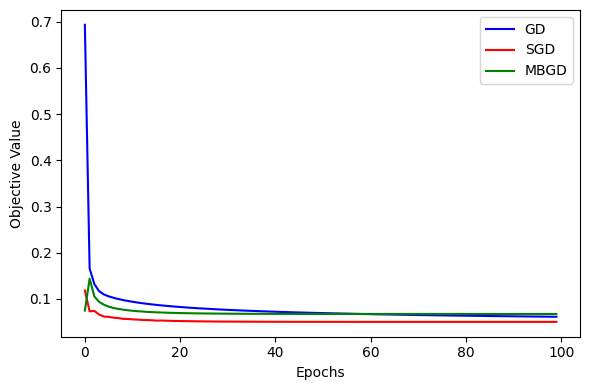

In [138]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals))
epochs_sgd = range(len(objvals_sgd))
epochs_mbgd = range(len(objvals_mbgd))

line0, = plt.plot(epochs_gd, objvals, '-b')
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r')
line2, = plt.plot(epochs_mbgd, objvals_mbgd, '-g')
plt.xlabel('Epochs')
plt.ylabel('Objective Value')
plt.xticks()
plt.yticks()
plt.legend([line0, line1, line2], ['GD', 'SGD', 'MBGD'])
plt.tight_layout()
plt.show()

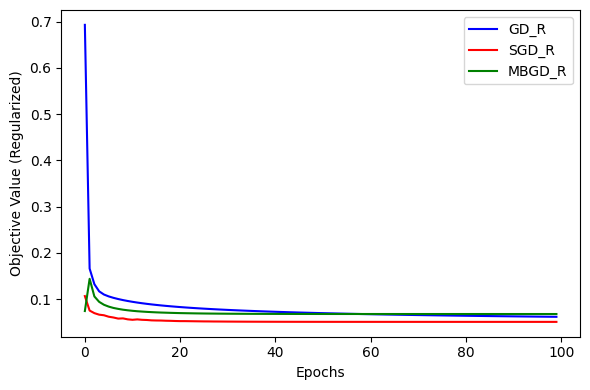

In [139]:
import matplotlib.pyplot as plt
%matplotlib inline

fig_r = plt.figure(figsize=(6, 4))

epochs_gd_r = range(len(objvals_r))
epochs_sgd_r = range(len(objvals_sgd_r))
epochs_mbgd_r = range(len(objvals_mbgd_r))

line0_r, = plt.plot(epochs_gd_r, objvals_r, '-b')
line1_r, = plt.plot(epochs_sgd_r, objvals_sgd_r, '-r')
line2_r, = plt.plot(epochs_mbgd_r, objvals_mbgd_r, '-g')
plt.xlabel('Epochs')
plt.ylabel('Objective Value (Regularized)')
plt.xticks()
plt.yticks()
plt.legend([line0_r, line1_r, line2_r], ['GD_R', 'SGD_R', 'MBGD_R'])
plt.tight_layout()
plt.show()

# 5. Prediction
### Compare the training and testing accuracy for logistic regression and regularized logistic regression.

In [151]:
# Predict class label
# Inputs:
#     w: weights: d-by-1 matrix
#     X: data: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    return np.sign(np.dot(X, w))

In [152]:
# evaluate training error of logistic regression and regularized version
f_train = predict(w_sgd, x_train)
diff = np.abs(f_train - y_train) / 2
error_train = np.mean(diff)
print('Training error: ' + str(error_train))
f_train_r = predict(w_sgd_r, x_train)
diff_r = np.abs(f_train_r - y_train) / 2
error_train_r = np.mean(diff_r)
print('Training error (regularized): ' + str(error_train_r))

Training error: 0.015384615384615385
Training error (regularized): 0.015384615384615385


In [153]:
# evaluate testing error of logistic regression and regularized version
f_test = predict(w_sgd, x_test)
diff = np.abs(f_test - y_test) / 2
error_test = np.mean(diff)
print('Testing error: ' + str(error_test))
f_test_r = predict(w_sgd_r, x_test)
diff_r = np.abs(f_test_r - y_test) / 2
error_test_r = np.mean(diff_r)
print('Testing error (regularized): ' + str(error_test_r))

Testing error: 0.0
Testing error (regularized): 0.0


# 6. Parameters tuning

### In this section, you may try different combinations of parameters (regularization value, learning rate, etc) to see their effects on the model. (Open ended question)

In [154]:
lam = 1E-6
learning_rate = 0.01
w_sgd_r_2, objvals_sgd_r_2 = sgd(x_train, y_train, lam, learning_rate, None)
lam = 1E-6
learning_rate = 0.001
w_sgd_r_3, objvals_sgd_r_3 = sgd(x_train, y_train, lam, learning_rate, None)

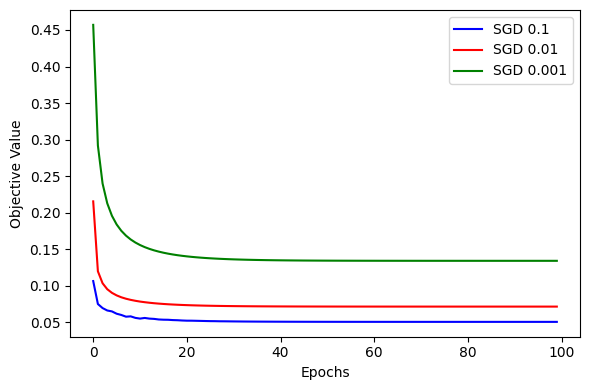

In [157]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_sgd = range(len(objvals_sgd_r))
epochs_sgd2 = range(len(objvals_sgd_r_2))
epochs_sgd3 = range(len(objvals_sgd_r_3))

line0, = plt.plot(epochs_sgd, objvals_sgd_r, '-b')
line1, = plt.plot(epochs_sgd2, objvals_sgd_r_2, '-r')
line2, = plt.plot(epochs_sgd3, objvals_sgd_r_3, '-g')
plt.xlabel('Epochs')
plt.ylabel('Objective Value')
plt.xticks()
plt.yticks()
plt.legend([line0, line1, line2], ['SGD 0.1', 'SGD 0.01', 'SGD 0.001'])
plt.tight_layout()
plt.show()